# Linear regression project - predicting the sale price of homes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
# read in training and test data
housing_train = pd.read_csv('../data/processed/train_features.csv', index_col = 'Id', keep_default_na = False)
housing_test = pd.read_csv('../data/processed/test_features.csv', index_col = 'Id', keep_default_na = False)

# Modeling and evaluation

## 1. Prepare data

In [4]:
# split housing_train into train and test sets
housing_train_features = housing_train.drop(columns=['SalePrice','Log Price'])
X_train, X_test, y_train, y_test = train_test_split(housing_train_features, housing_train['Log Price'], random_state=42)

## 2. Modeling

In [5]:
class OneHotEncoderWrapper(OneHotEncoder):
    
    '''
    wrapper class for one hot encoder that also allows access to final column names as a method
    '''
    
    # imputs taken from OneHotEncoder
    def __init__(self, verbose=0, cols=None, drop_invariant=False, wrapper_return_df=True, 
                 impute_missing=True, handle_unknown='impute', use_cat_names=False):
        
        self.wrapper_return_df = wrapper_return_df
        
        # turn return_df to True for parent to allow access to df column names
        super().__init__(verbose=verbose, cols=cols, drop_invariant=drop_invariant, return_df=True, 
                         impute_missing=impute_missing, handle_unknown=handle_unknown, use_cat_names=use_cat_names)
        
        self.feature_names = None

    def fit(self, X, y=None):
        super().fit(X)
        return self

    def transform(self, X):
        df = super().transform(X)
        self.feature_names = df.columns
        if self.wrapper_return_df:
            return df
        else:
            return df.values
    
    def get_feature_names(self):
        return self.feature_names

In [6]:
# set up pipeline

pipe = Pipeline([
    # one hot encodes all object columns, keeping all features
    ('enc', OneHotEncoderWrapper(use_cat_names=True, wrapper_return_df=True, 
                                 handle_unknown='Ignore', impute_missing=False)),
    # scales features for easier comparison of importance
    ('ss', StandardScaler()),
    # regularization to limit overfitting
    ('ridge', Ridge()),
])

In [7]:
# RandomizedSearch for optimal alpha

param_dist = {
    'ridge__alpha': np.linspace(10,1000,10000)
}

random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter = 20, 
                                   return_train_score=False, scoring='neg_mean_squared_error', cv=10, random_state=42)
random_search.fit(X_train, y_train);

In [8]:
print(random_search.best_params_)

{'ridge__alpha': 56.13861386138614}


## 3. Evaluation

In [9]:
# Check RMSE

train_predict = random_search.predict(X_train)
train_rmse = (mean_squared_error(np.exp(y_train), np.exp(train_predict))**0.5)
              
test_predict = random_search.predict(X_test)
test_rmse = (mean_squared_error(np.exp(y_test), np.exp(test_predict))**0.5)

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 18924.69230350529
Test RMSE: 21036.773008983306


In [10]:
## score seems reasonable - not too overfit

## 4. Model analysis

### Analysis of features

In [11]:
# look at parameters
coef = random_search.best_estimator_.named_steps['ridge'].coef_
features = random_search.best_estimator_.named_steps['enc'].get_feature_names()

coef = pd.DataFrame(coef.T, columns = ['coefs'], index = features)

coef_abs = pd.DataFrame(coef['coefs'].map(lambda x: abs(x)).sort_values(ascending=False))
coef_abs['sign'] = coef['coefs'].map(lambda x: 1 if x>0 else -1)
coef_abs.reset_index(inplace=True)

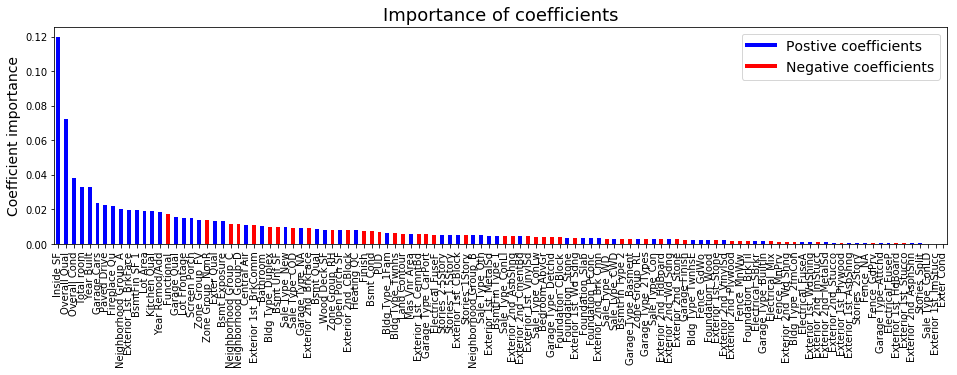

In [12]:
colors = coef_abs['sign'].map(lambda x: 'blue' if x==1 else 'red')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4)]

fig = plt.figure(figsize=(16,4))
ax = plt.gca()

coef_abs.plot(x='index',y='coefs', kind='bar', color=colors, ax=ax)
ax.legend(labels=['Positive','Negative'])
ax.set_title('Importance of coefficients', fontsize='18')
ax.set_xlabel('')
ax.set_ylabel('Coefficient importance', fontsize=14)
ax.legend(custom_lines, ['Postive coefficients', 'Negative coefficients'], fontsize='14');

In [13]:
## Five most important features are: Inside SF, Overall Qual, Overall Cond, Total room, Year Built

### Visualization of errors

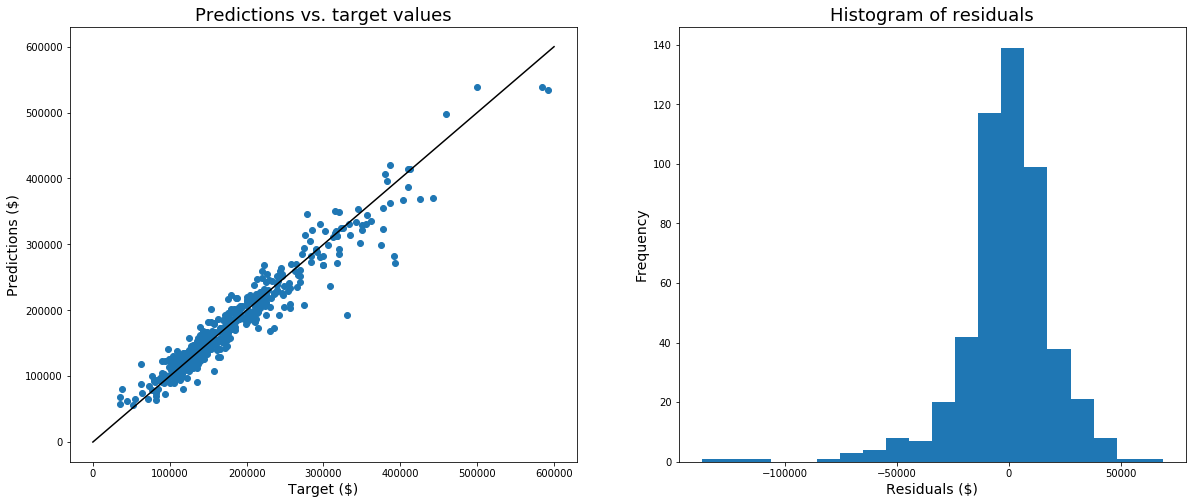

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))

ax[0].scatter(np.exp(y_test), np.exp(test_predict))
ax[0].plot([0, 600000], [0, 600000], c='k')
ax[0].set_title('Predictions vs. target values', fontsize='18')
ax[0].set_ylabel('Predictions ($)', fontsize='14')
ax[0].set_xlabel('Target ($)', fontsize='14')

residuals = np.exp(test_predict) - np.exp(y_test)
ax[1].hist(residuals, bins=20)
ax[1].set_title('Histogram of residuals', fontsize='18')
ax[1].set_ylabel('Frequency', fontsize='14')
ax[1].set_xlabel('Residuals ($)', fontsize='14');

In [15]:
## Residuals are pretty symmetric, although with a left tail, caused by some mid-range under-predictions

## 5. Make real predictions

In [16]:
# run model on real test set and save results
model_predict = np.exp(random_search.predict(housing_test))

# # fit and save model
model_predict_df = pd.DataFrame(model_predict, columns=['SalePrice'], index=housing_test.index.astype(int))
model_predict_df.to_csv('../data/output/model_submission.csv')